# DuckDB Warehouse Setup

This notebook sets up the DuckDB warehouse for all processed segments.

**What it does:**
- Loads 1s aggregates from all processed segments
- Creates multi-granularity views (5s, 1m, 5m, 15m)
- Creates analytics and summary views
- Prepares data for Power BI dashboard

**Prerequisites:** Make sure all the segments order books have been generated and aggreagted in `data_segments/` folder. Otherwise, run `1_batch_process_all_segments.ipynb` first to generate segment data.

## Setup Environment

In [1]:
# Environment setup
import os

REPO_DIR = '/content/drive/MyDrive/00_EUREX/eurex-liquidity-demo'
assert os.path.exists(REPO_DIR), f'Repo not found: {REPO_DIR}'

DATA_DIR = f"{REPO_DIR}/data_segments"
DB_PATH = f"{REPO_DIR}/warehouse/eurex.duckdb"

print("Environment configured")
print(f"   Repo: {REPO_DIR}")
print(f"   Data: {DATA_DIR}")
print(f"   DB:   {DB_PATH}")

Environment configured
   Repo: /content/drive/MyDrive/00_EUREX/eurex-liquidity-demo
   Data: /content/drive/MyDrive/00_EUREX/eurex-liquidity-demo/data_segments
   DB:   /content/drive/MyDrive/00_EUREX/eurex-liquidity-demo/warehouse/eurex.duckdb


## Check Processed Segments

Verify that segment data exists before building the warehouse.

In [2]:
# Check available segments
import glob
from pathlib import Path

# Find all 1s aggregate files
agg_pattern = f"{DATA_DIR}/seg_*/l*/*_agg_1s_*.parquet"
agg_files = glob.glob(agg_pattern)

print(f"Found {len(agg_files)} aggregate files")
print("="*70)

if agg_files:
    for f in sorted(agg_files):
        rel_path = Path(f).relative_to(DATA_DIR)
        size_mb = Path(f).stat().st_size / 1024 / 1024
        print(f"  {rel_path} ({size_mb:.2f} MB)")
    print(f"\nReady to build warehouse")
else:
    print("⚠️  No aggregate files found!")
    print(f"   Expected pattern: {agg_pattern}")
    print("   Run 4_batch_process_all_segments.ipynb first")

Found 6 aggregate files
  seg_1209/l4/l4_agg_1s_seg1209.parquet (0.01 MB)
  seg_48/l5/l5_agg_1s_seg48.parquet (0.08 MB)
  seg_589/l5/l5_agg_1s_seg589.parquet (4.73 MB)
  seg_688/l2/l2_agg_1s_seg688.parquet (46.48 MB)
  seg_702/l5/l5_agg_1s_seg702.parquet (0.02 MB)
  seg_821/l5/l5_agg_1s_seg821.parquet (4.75 MB)

Ready to build warehouse


## Build DuckDB Warehouse

Run the setup script to create tables and views.

In [3]:
# Close any existing connections
try:
    con.close()
    print("✅ Closed existing connection")
except:
    print("ℹ️  No existing connection to close")

ℹ️  No existing connection to close


In [4]:
# Build warehouse
!python "{REPO_DIR}/scripts/setup_duckdb_warehouse.py" \
  --db-path "{DB_PATH}" \
  --data-dir "{DATA_DIR}" \
  --recreate

# Reconnect after rebuild
import duckdb
con = duckdb.connect(DB_PATH, read_only=False)
print(f"\n✅ Reconnected to {DB_PATH}")

EUREX LIQUIDITY ANALYSIS - DUCKDB WAREHOUSE SETUP
Database: /content/drive/MyDrive/00_EUREX/eurex-liquidity-demo/warehouse/eurex.duckdb
Data dir: /content/drive/MyDrive/00_EUREX/eurex-liquidity-demo/data_segments
Mode:     RECREATE

Connecting to DuckDB...
✅ Connected to /content/drive/MyDrive/00_EUREX/eurex-liquidity-demo/warehouse/eurex.duckdb

[1/5] Loading 1s aggregates from all segments...
Mode: RECREATE
Found 6 aggregate files

🔄 FULL REFRESH MODE: Dropping and recreating table...
  - seg_1209/l4/l4_agg_1s_seg1209.parquet
  - seg_48/l5/l5_agg_1s_seg48.parquet
  - seg_589/l5/l5_agg_1s_seg589.parquet
  - seg_688/l2/l2_agg_1s_seg688.parquet
  - seg_702/l5/l5_agg_1s_seg702.parquet
  - seg_821/l5/l5_agg_1s_seg821.parquet

Loading files with segment_id extraction...
  ✅ Loaded segment 48: l5_agg_1s_seg48.parquet
  ✅ Loaded segment 821: l5_agg_1s_seg821.parquet
  ✅ Loaded segment 702: l5_agg_1s_seg702.parquet
  ✅ Loaded segment 589: l5_agg_1s_seg589.parquet
  ✅ Loaded segment 1209: l4_a

## Connect and Explore

Connect to the database and explore the structure.

In [26]:
# Connect to DuckDB
import duckdb
import pandas as pd

con = duckdb.connect(DB_PATH, read_only=False)

print(f"Connected to {DB_PATH}\n")

# Show tables
tables = con.execute("SHOW TABLES").df()
print("Tables:")
print(tables.to_string(index=False))

# Show views (FIXED: use information_schema instead of duckdb_views())
views = con.execute("""
    SELECT table_name 
    FROM information_schema.tables 
    WHERE table_type = 'VIEW' 
    ORDER BY table_name
""").df()
print(f"\nViews:")
print(views.to_string(index=False))

# Quick row count check
print(f"\nRow Counts:")
print(f"  metrics_1s: {con.execute('SELECT COUNT(*) FROM metrics_1s').fetchone()[0]:,}")
print(f"  metrics_5s: {con.execute('SELECT COUNT(*) FROM metrics_5s').fetchone()[0]:,}")
print(f"  metrics_1m: {con.execute('SELECT COUNT(*) FROM metrics_1m').fetchone()[0]:,}")

Connected to /content/drive/MyDrive/00_EUREX/eurex-liquidity-demo/warehouse/eurex.duckdb

Tables:
                name
  amihud_illiquidity
kyle_lambda_security
 kyle_lambda_segment
          metrics_1m
          metrics_1s
          metrics_5m
          metrics_5s
    security_summary
     segment_summary
spread_decomposition
      top_securities

Views:
         table_name
         metrics_1m
         metrics_5m
         metrics_5s
   security_summary
    segment_summary
     top_securities
v_l1_enriched_seg48
   v_l1_vs_l5_seg48
v_l5_enriched_seg48

Row Counts:
  metrics_1s: 1,252,799
  metrics_5s: 1,244,035
  metrics_1m: 1,244,035


## Explore Base Data (1s aggregates)

In [27]:
# Check base table
print("BASE TABLE: metrics_1s")
print("="*70)

# Row count
row_count = con.execute("SELECT COUNT(*) FROM metrics_1s").fetchone()[0]
print(f"Total rows: {row_count:,}")

# Segments
segments = con.execute("SELECT DISTINCT segment_id FROM metrics_1s ORDER BY segment_id").df()
print(f"\nSegments: {segments['segment_id'].tolist()}")

# Sample data
print("\nSample (first 5 rows):")
sample = con.execute("SELECT * FROM metrics_1s LIMIT 5").df()
display(sample)

# Column info
print("\nColumns:")
for col in sample.columns:
    print(f"  - {col}")

BASE TABLE: metrics_1s
Total rows: 1,252,799

Segments: [48, 589, 688, 702, 821, 1209]

Sample (first 5 rows):


,security_id,ts_s,best_bid,best_ask,bid_size_1,ask_size_1,spread_abs,spread_rel,midprice,imbalance_l1,...,avg_bid_price,avg_ask_price,imbalance_l5,microprice_l5,depth_ratio,total_volume,volume_ratio_l1_to_l5,update_count,cancel_count,segment_id
0,2788279,1606809697,269.9571,270.9045,5.0,5.0,0.9474,0.003503,270.43080,0.0,...,269.812767,270.768300,0.0,270.290533,1.0,30.0,0.333333,2.0,0.0,48
1,2788279,1606809701,269.6577,270.6040,5.0,5.0,0.9463,0.003503,270.13085,0.0,...,269.729567,270.668167,0.0,270.198867,1.0,30.0,0.333333,NaN,NaN,48
2,2788279,1606809778,269.8074,270.7542,5.0,5.0,0.9468,0.003503,270.28080,0.0,...,269.663067,270.654067,0.0,270.158567,1.0,30.0,0.333333,NaN,NaN,48
3,2788279,1606809810,269.6577,270.4538,5.0,5.0,0.7961,0.002948,270.05575,0.0,...,269.729567,270.634800,0.0,270.182183,1.0,30.0,0.333333,NaN,NaN,48
4,2788279,1606809816,270.1068,271.0547,5.0,5.0,0.9479,0.003503,270.58075,0.0,...,269.629767,270.584667,0.0,270.107217,1.0,30.0,0.333333,NaN,NaN,48



Columns:
  - security_id
  - ts_s
  - best_bid
  - best_ask
  - bid_size_1
  - ask_size_1
  - spread_abs
  - spread_rel
  - midprice
  - imbalance_l1
  - microprice_l1
  - total_bid_volume
  - total_ask_volume
  - avg_bid_price
  - avg_ask_price
  - imbalance_l5
  - microprice_l5
  - depth_ratio
  - total_volume
  - volume_ratio_l1_to_l5
  - update_count
  - cancel_count
  - segment_id


## Explore Time Aggregation Views

In [28]:
# Check view row counts
print("TIME AGGREGATION VIEWS")
print("="*70)

for view in ['metrics_1s', 'metrics_5s', 'metrics_1m', 'metrics_5m']:
    count = con.execute(f"SELECT COUNT(*) FROM {view}").fetchone()[0]
    print(f"{view:15s}: {count:,} rows")

# Sample 5s data
print("\n📊 Sample from metrics_5s (5-second aggregates):")
sample_5s = con.execute("""
    SELECT 
        segment_id,
        security_id,
        ts_s,
        avg_spread_bps,
        avg_imbalance,
        total_updates,
        avg_bid_size,
        avg_ask_size
    FROM metrics_5s 
    LIMIT 10
""").df()
display(sample_5s)

TIME AGGREGATION VIEWS
metrics_1s     : 1,252,799 rows
metrics_5s     : 1,244,035 rows
metrics_1m     : 1,244,035 rows
metrics_5m     : 1,244,035 rows

📊 Sample from metrics_5s (5-second aggregates):


,segment_id,security_id,ts_s,avg_spread_bps,avg_imbalance,total_updates,avg_bid_size,avg_ask_size
0,48,2788279,1.606810e+09,35.032992,0.0,2.0,5.0,5.0
1,48,2788279,1.606810e+09,35.031171,0.0,NaN,5.0,5.0
2,48,2788279,1.606810e+09,35.030235,0.0,NaN,5.0,5.0
3,48,2788279,1.606810e+09,29.479098,0.0,NaN,5.0,5.0
4,48,2788279,1.606810e+09,35.032056,0.0,NaN,5.0,5.0
5,48,2788279,1.606810e+09,35.997179,0.0,NaN,5.0,5.0
6,48,2788279,1.606810e+09,35.033100,0.0,NaN,5.0,5.0
7,48,2788279,1.606810e+09,35.031121,0.0,NaN,5.0,5.0
8,48,2788279,1.606810e+09,35.030283,0.0,NaN,5.0,5.0
9,48,2788279,1.606810e+09,35.032992,0.0,NaN,5.0,5.0


## Explore Analytics Views

In [29]:
# Segment summary
print("SEGMENT SUMMARY")
print("="*70)

seg_summary = con.execute("SELECT * FROM segment_summary ORDER BY segment_id").df()
display(seg_summary)

# Top securities by activity
print("\nTOP 10 SECURITIES BY UPDATES")
print("="*70)

top_sec = con.execute("SELECT * FROM top_securities LIMIT 10").df()
display(top_sec)

SEGMENT SUMMARY


,segment_id,num_securities,num_1s_intervals,first_ts_s,last_ts_s,trading_hours,avg_spread_bps,median_spread_bps,min_spread_bps,max_spread_bps,total_updates,total_cancels,updates_per_sec,avg_total_depth_l1,num_two_sided_quotes,num_ask_only_quotes,num_bid_only_quotes
0,48,1,2725,1606809697,1606840200,8.473056,33.494530,35.031221,-64.233903,101.317914,2032.0,0.0,0.066616,10.000000,2725.0,0.0,0.0
1,589,6,153058,1606781706,1606856400,20.748333,11.971320,2.614135,-77142.857143,56190.476190,3301758.0,0.0,44.203791,5.207255,153054.0,4.0,0.0
2,688,246,974894,1606781709,1606856400,20.747500,-178.983917,11.454754,-20545.940295,20573.576178,3139530.0,0.0,42.033578,3053.904475,966341.0,142.0,8411.0
3,702,2,344,1606806120,1606845489,10.935833,1.250794,1.491832,0.497302,1.989456,592.0,0.0,0.015037,397.447674,341.0,3.0,0.0
4,821,33,121771,1606806267,1606856400,13.925833,449.555306,444.444444,-340000.000000,140000.000000,314400.0,0.0,6.271318,218.485485,121574.0,49.0,116.0
5,1209,7,7,1606806120,1606806120,0.000000,NaN,NaN,NaN,NaN,12.0,0.0,NaN,19.285714,0.0,7.0,0.0



TOP 10 SECURITIES BY UPDATES


,segment_id,security_id,total_updates,avg_spread_bps,median_spread_bps,avg_imbalance,avg_total_depth_l1,updates_per_sec
0,589,5035771,2266977.0,7.527635,5.981085,0.002675,6.910774,30.350189
1,589,5336359,596743.0,1.476597,1.121432,0.111064,4.527559,7.989169
2,589,5594748,437362.0,2.761324,2.613842,0.031019,3.514854,5.855383
3,688,12,59915.0,14.400291,13.545547,0.018405,244.415133,0.802172
4,688,13,59494.0,-355.236411,1.688761,-0.055603,766.047828,0.796535
5,688,14,58434.0,2392.126730,-10.139131,0.114441,3265.546904,0.782343
6,688,11,58177.0,-2.586829,12.963224,0.043782,233.755327,0.778902
7,688,15,57168.0,-829.642844,-12.394366,-0.033336,842.761852,0.765393
8,688,10,54748.0,1940.607670,16.880486,0.141990,2725.305096,0.732993
9,688,16,54479.0,26.128304,-14.084110,0.060009,257.126364,0.729392


## Test Dashboard Queries

Test the types of queries Power BI will use.

QUERY 1: Intraday Spread Evolution - All Segments (5s)
Segments to plot: [48, 589, 688, 702, 821]

Segment 48: 2,725 data points
Segment 589: 153,054 data points
Segment 688: 966,341 data points
Segment 702: 341 data points
Segment 821: 121,574 data points


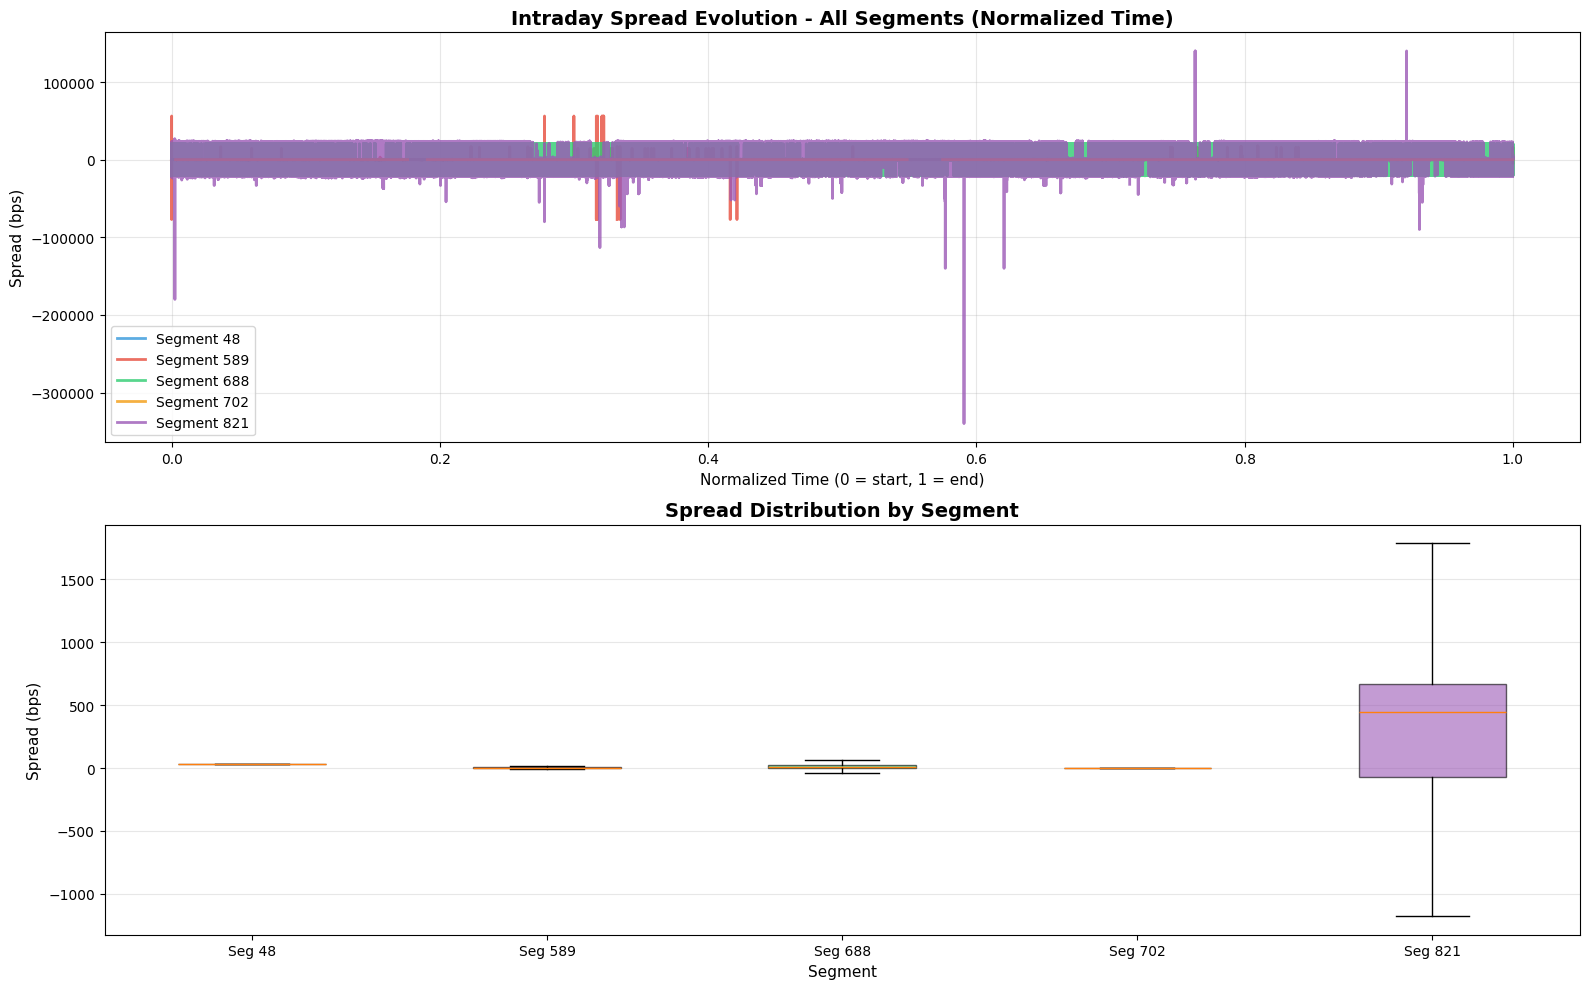


SUMMARY STATISTICS


,Segment,Mean Spread (bps),Median Spread (bps),Std Dev,Min,Max,Data Points
0,48,33.49,35.03,10.80,-64.23,101.32,2725
1,589,11.97,2.61,797.37,-77142.86,56190.48,153054
2,688,-178.98,11.45,5233.79,-20545.94,20573.58,966341
3,702,1.25,1.49,0.39,0.50,1.99,341
4,821,449.56,444.44,9892.85,-340000.00,140000.00,121574


In [30]:
# Query 1: Spread over time for ALL segments (5s granularity)
print("QUERY 1: Intraday Spread Evolution - All Segments (5s)")
print("="*70)

# Get all segments
segments = con.execute("SELECT DISTINCT segment_id FROM metrics_5s ORDER BY segment_id").df()['segment_id'].tolist()
print(f"Segments to plot: {segments}\n")

# Fetch data for all segments
spread_data = {}
for seg in segments:
    df = con.execute(f"""
        SELECT 
            segment_id,
            ts_s,
            avg_spread_bps,
            min_spread_bps,
            max_spread_bps,
            ROW_NUMBER() OVER (ORDER BY ts_s) as time_idx
        FROM metrics_5s
        WHERE segment_id = {seg}
        ORDER BY ts_s
    """).df()
    spread_data[seg] = df
    print(f"Segment {seg}: {len(df):,} data points")

# Visualize - all segments on one chart
import matplotlib.pyplot as plt

# Define colors for each segment
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6', '#1abc9c']

fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Top panel: All segments together (line plot)
ax1 = axes[0]
for i, seg in enumerate(segments):
    df = spread_data[seg]
    # Use normalized time index (0 to 1) for comparable x-axis
    x_norm = df['time_idx'] / len(df)
    ax1.plot(x_norm, df['avg_spread_bps'], 
             label=f'Segment {seg}', 
             linewidth=2, 
             color=colors[i % len(colors)],
             alpha=0.8)

ax1.set_title('Intraday Spread Evolution - All Segments (Normalized Time)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Normalized Time (0 = start, 1 = end)', fontsize=11)
ax1.set_ylabel('Spread (bps)', fontsize=11)
ax1.legend(loc='best', fontsize=10)
ax1.grid(True, alpha=0.3)

# Bottom panel: Box plot comparison
ax2 = axes[1]
spread_values = [spread_data[seg]['avg_spread_bps'].dropna() for seg in segments]
bp = ax2.boxplot(spread_values, 
                  labels=[f'Seg {seg}' for seg in segments],
                  patch_artist=True,
                  showfliers=False)  # Hide outliers for clarity

# Color the boxes
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

ax2.set_title('Spread Distribution by Segment', fontsize=14, fontweight='bold')
ax2.set_xlabel('Segment', fontsize=11)
ax2.set_ylabel('Spread (bps)', fontsize=11)
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Summary statistics
print("\n" + "="*70)
print("SUMMARY STATISTICS")
print("="*70)
summary_data = []
for seg in segments:
    df = spread_data[seg]
    summary_data.append({
        'Segment': seg,
        'Mean Spread (bps)': df['avg_spread_bps'].mean(),
        'Median Spread (bps)': df['avg_spread_bps'].median(),
        'Std Dev': df['avg_spread_bps'].std(),
        'Min': df['avg_spread_bps'].min(),
        'Max': df['avg_spread_bps'].max(),
        'Data Points': len(df)
    })

import pandas as pd
summary_df = pd.DataFrame(summary_data)
display(summary_df.round(2))

QUERY 2: Cross-Segment Comparison - All Metrics


,segment_id,avg_spread,avg_imbalance,total_updates,avg_depth
0,48,33.49,0.00,2032.0,10.00
1,589,11.97,0.04,3301751.0,5.21
2,688,-178.98,0.02,3123335.0,2810.93
3,702,1.25,-0.01,592.0,400.94
4,821,449.56,0.01,314031.0,218.09


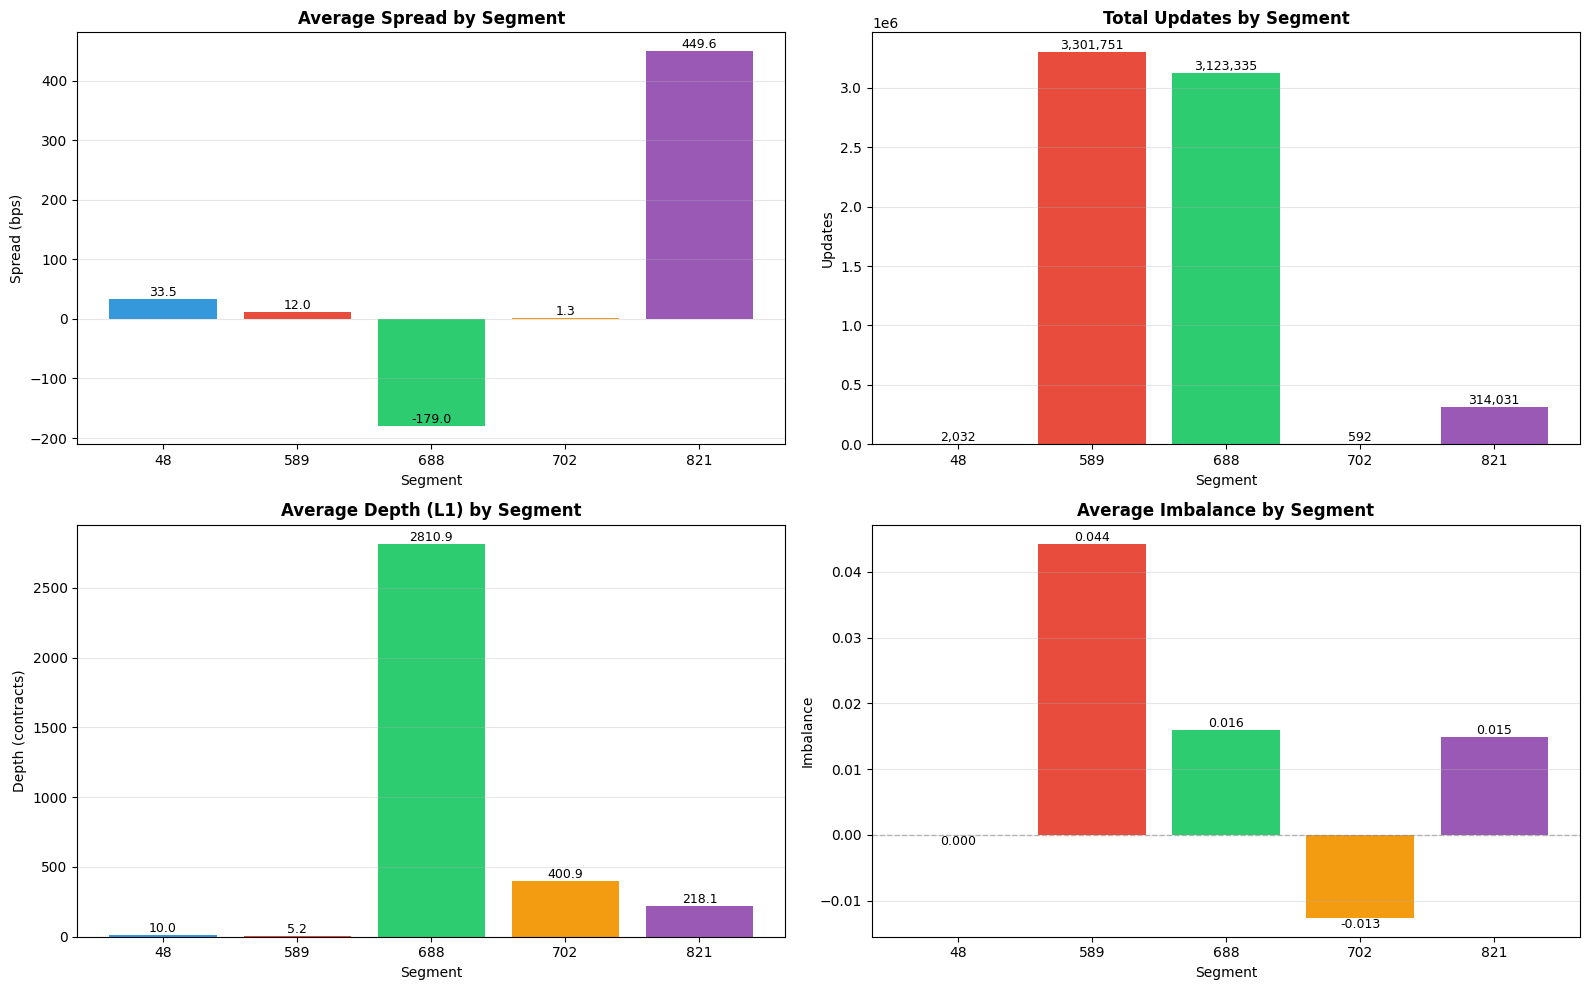


KEY INSIGHTS
📊 Most Active: Segment 589
💰 Widest Spread: Segment 821
📈 Deepest Book: Segment 688


In [31]:
# Query 2: Cross-Segment Comparison - Multiple Metrics
print("QUERY 2: Cross-Segment Comparison - All Metrics")
print("="*70)

# Aggregate comparison across all segments
segment_comp = con.execute("""
    SELECT 
        segment_id,
        AVG(avg_spread_bps) AS avg_spread,
        AVG(avg_imbalance) AS avg_imbalance,
        SUM(total_updates) AS total_updates,
        AVG(avg_bid_size + avg_ask_size) AS avg_depth
    FROM metrics_1m
    GROUP BY segment_id
    ORDER BY segment_id
""").df()

display(segment_comp.round(2))

# Visualize - 4 subplots for different metrics
import matplotlib.pyplot as plt

colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6']
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Average Spread
ax1 = axes[0, 0]
bars1 = ax1.bar(segment_comp['segment_id'].astype(str), segment_comp['avg_spread'], color=colors[:len(segment_comp)])
ax1.set_title('Average Spread by Segment', fontsize=12, fontweight='bold')
ax1.set_xlabel('Segment', fontsize=10)
ax1.set_ylabel('Spread (bps)', fontsize=10)
ax1.grid(True, alpha=0.3, axis='y')
# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}', ha='center', va='bottom', fontsize=9)

# 2. Total Updates
ax2 = axes[0, 1]
bars2 = ax2.bar(segment_comp['segment_id'].astype(str), segment_comp['total_updates'], color=colors[:len(segment_comp)])
ax2.set_title('Total Updates by Segment', fontsize=12, fontweight='bold')
ax2.set_xlabel('Segment', fontsize=10)
ax2.set_ylabel('Updates', fontsize=10)
ax2.grid(True, alpha=0.3, axis='y')
# Add value labels
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:,.0f}', ha='center', va='bottom', fontsize=9)

# 3. Average Depth
ax3 = axes[1, 0]
bars3 = ax3.bar(segment_comp['segment_id'].astype(str), segment_comp['avg_depth'], color=colors[:len(segment_comp)])
ax3.set_title('Average Depth (L1) by Segment', fontsize=12, fontweight='bold')
ax3.set_xlabel('Segment', fontsize=10)
ax3.set_ylabel('Depth (contracts)', fontsize=10)
ax3.grid(True, alpha=0.3, axis='y')
# Add value labels
for bar in bars3:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}', ha='center', va='bottom', fontsize=9)

# 4. Average Imbalance
ax4 = axes[1, 1]
bars4 = ax4.bar(segment_comp['segment_id'].astype(str), segment_comp['avg_imbalance'], color=colors[:len(segment_comp)])
ax4.set_title('Average Imbalance by Segment', fontsize=12, fontweight='bold')
ax4.set_xlabel('Segment', fontsize=10)
ax4.set_ylabel('Imbalance', fontsize=10)
ax4.axhline(y=0, color='gray', linestyle='--', alpha=0.5, linewidth=1)
ax4.grid(True, alpha=0.3, axis='y')
# Add value labels
for bar in bars4:
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}', ha='center', va='bottom' if height > 0 else 'top', fontsize=9)

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("KEY INSIGHTS")
print("="*70)
print(f"📊 Most Active: Segment {segment_comp.loc[segment_comp['total_updates'].idxmax(), 'segment_id']}")
print(f"💰 Widest Spread: Segment {segment_comp.loc[segment_comp['avg_spread'].idxmax(), 'segment_id']}")
print(f"📈 Deepest Book: Segment {segment_comp.loc[segment_comp['avg_depth'].idxmax(), 'segment_id']}")

📊 QUERY 3: Order Book Imbalance vs Spread - All Segments
📊 Total data points: 1,228,060
📊 Segments: [np.int32(48), np.int32(589), np.int32(688), np.int32(702), np.int32(821)]

  Segment 48: 2,725 points
  Segment 589: 152,497 points
  Segment 688: 951,502 points
  Segment 702: 330 points
  Segment 821: 121,006 points


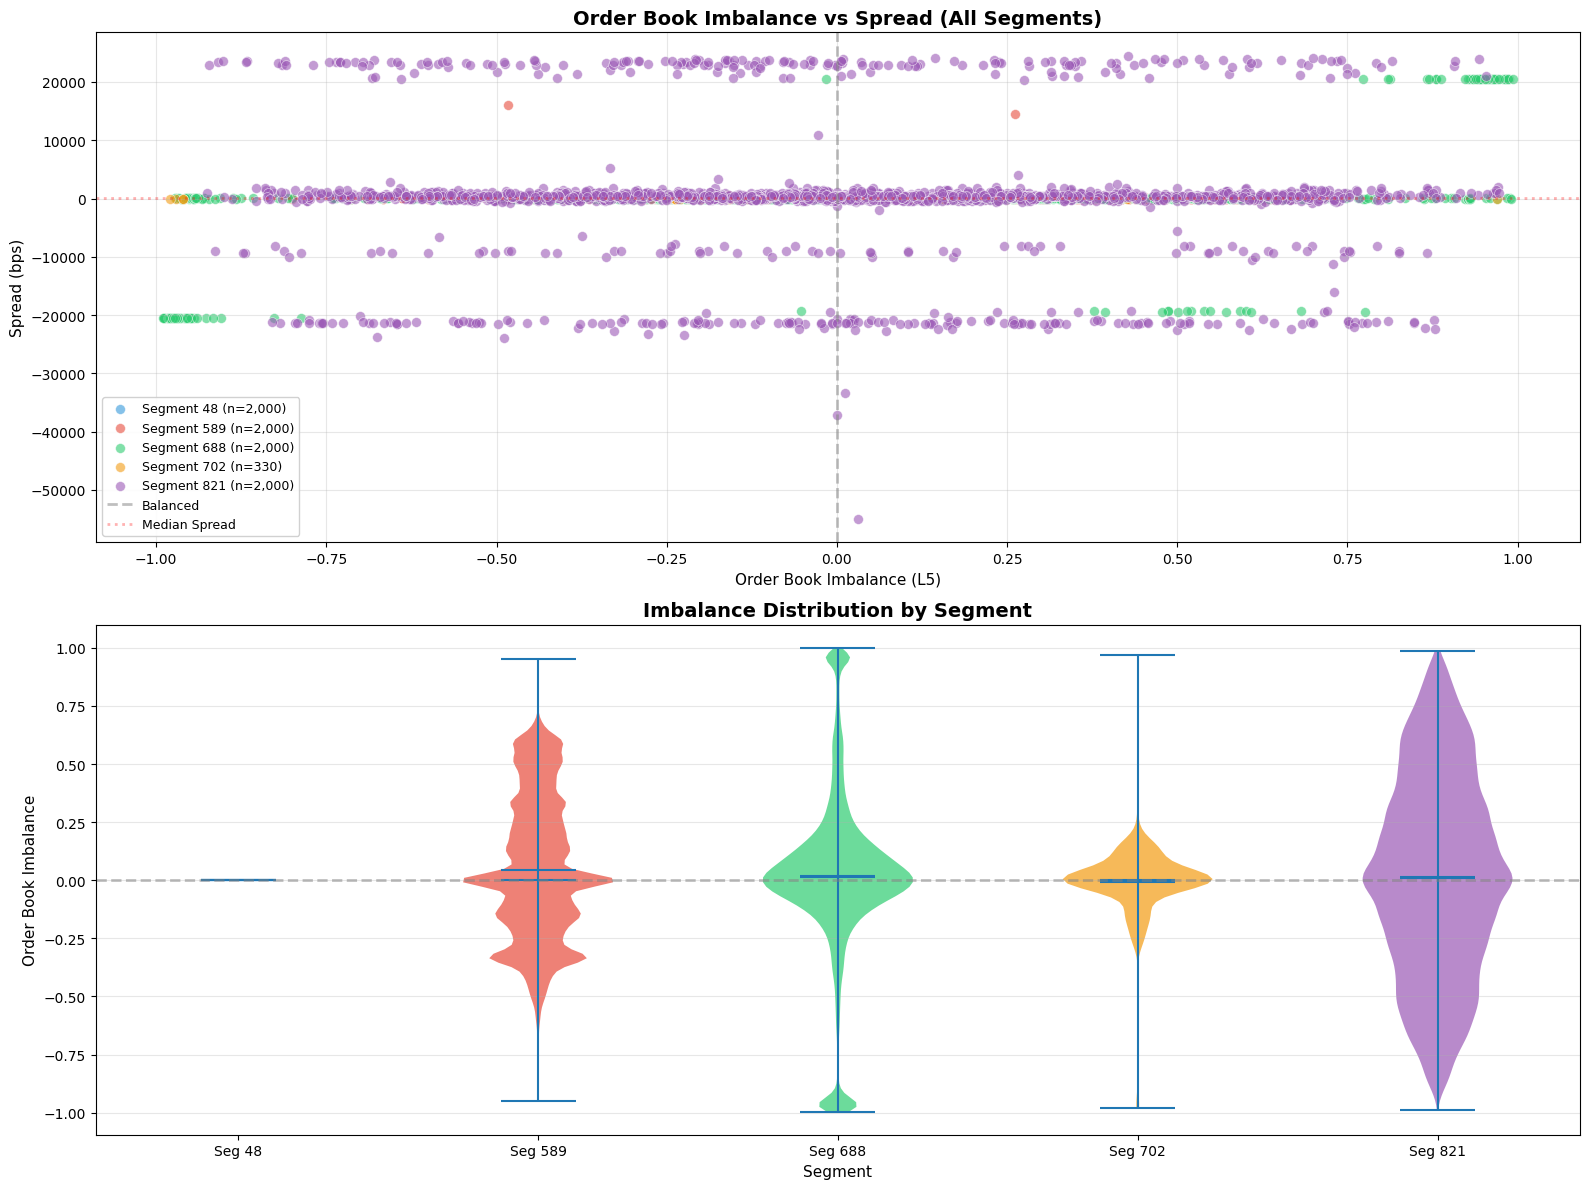


📊 SUMMARY BY SEGMENT


,Segment,Count,Mean Imbalance,Std Imbalance,Mean Spread (bps),Median Spread (bps),Total Updates
0,48,2725,0.0000,0.0000,33.4945,35.0312,2032.0
1,589,152497,0.0443,0.3038,11.9713,2.6141,3291797.0
2,688,951502,0.0163,0.3572,-178.9839,11.4548,3075106.0
3,702,330,-0.0073,0.1530,1.2508,1.4918,582.0
4,821,121006,0.0144,0.4268,449.5553,444.4444,312556.0



🔗 CORRELATION: Imbalance vs Spread (by segment)
  Segment 48: correlation = nan
  Segment 589: correlation = 0.0148
  Segment 688: correlation = 0.6143
  Segment 702: correlation = -0.0248
  Segment 821: correlation = -0.0351


In [32]:
# Query 3: Imbalance vs Spread Analysis - All Segments
print("📊 QUERY 3: Order Book Imbalance vs Spread - All Segments")
print("="*70)

# Fetch data for all segments
imbalance_data = con.execute("""
    SELECT 
        segment_id,
        avg_imbalance,
        avg_spread_bps,
        total_updates
    FROM metrics_1m
    WHERE avg_imbalance IS NOT NULL AND avg_spread_bps IS NOT NULL
    ORDER BY segment_id, ts_s
""").df()

print(f"📊 Total data points: {len(imbalance_data):,}")
print(f"📊 Segments: {sorted(imbalance_data['segment_id'].unique())}\n")

# Count by segment
seg_counts = imbalance_data['segment_id'].value_counts().sort_index()
for seg, count in seg_counts.items():
    print(f"  Segment {seg}: {count:,} points")

# Visualize
import matplotlib.pyplot as plt

colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6', '#1abc9c']
segments = sorted(imbalance_data['segment_id'].unique())

fig, axes = plt.subplots(2, 1, figsize=(16, 12))

# Top: Scatter plot - Imbalance vs Spread
ax1 = axes[0]
for i, seg_id in enumerate(segments):
    seg_data = imbalance_data[imbalance_data['segment_id'] == seg_id]
    # Sample if too many points (for performance)
    if len(seg_data) > 2000:
        seg_data = seg_data.sample(n=2000, random_state=42)
    
    ax1.scatter(seg_data['avg_imbalance'], 
                seg_data['avg_spread_bps'],
                c=colors[i % len(colors)],
                label=f'Segment {seg_id} (n={len(seg_data):,})',
                alpha=0.6,
                s=50,
                edgecolors='white',
                linewidth=0.5)

ax1.axvline(x=0, color='gray', linestyle='--', alpha=0.5, linewidth=2, label='Balanced')
ax1.axhline(y=imbalance_data['avg_spread_bps'].median(), 
            color='red', linestyle=':', alpha=0.3, linewidth=2, label='Median Spread')

ax1.set_title('Order Book Imbalance vs Spread (All Segments)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Order Book Imbalance (L5)', fontsize=11)
ax1.set_ylabel('Spread (bps)', fontsize=11)
ax1.legend(loc='best', framealpha=0.9, fontsize=9)
ax1.grid(True, alpha=0.3)

# Bottom: Imbalance distribution by segment (violin plot)
ax2 = axes[1]
imbalance_by_seg = [imbalance_data[imbalance_data['segment_id'] == seg]['avg_imbalance'].dropna().values 
                    for seg in segments]

parts = ax2.violinplot(imbalance_by_seg, 
                       positions=range(len(segments)),
                       showmeans=True,
                       showmedians=True)

# Color the violins
for i, pc in enumerate(parts['bodies']):
    pc.set_facecolor(colors[i % len(colors)])
    pc.set_alpha(0.7)

ax2.axhline(y=0, color='gray', linestyle='--', alpha=0.5, linewidth=2)
ax2.set_xticks(range(len(segments)))
ax2.set_xticklabels([f'Seg {seg}' for seg in segments])
ax2.set_title('Imbalance Distribution by Segment', fontsize=14, fontweight='bold')
ax2.set_xlabel('Segment', fontsize=11)
ax2.set_ylabel('Order Book Imbalance', fontsize=11)
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Summary statistics by segment
print("\n" + "="*70)
print("📊 SUMMARY BY SEGMENT")
print("="*70)

summary_list = []
for seg in segments:
    seg_data = imbalance_data[imbalance_data['segment_id'] == seg]
    summary_list.append({
        'Segment': seg,
        'Count': len(seg_data),
        'Mean Imbalance': seg_data['avg_imbalance'].mean(),
        'Std Imbalance': seg_data['avg_imbalance'].std(),
        'Mean Spread (bps)': seg_data['avg_spread_bps'].mean(),
        'Median Spread (bps)': seg_data['avg_spread_bps'].median(),
        'Total Updates': seg_data['total_updates'].sum()
    })

import pandas as pd
summary_df = pd.DataFrame(summary_list)
display(summary_df.round(4))

# Correlation analysis
print("\n" + "="*70)
print("🔗 CORRELATION: Imbalance vs Spread (by segment)")
print("="*70)
for seg in segments:
    seg_data = imbalance_data[imbalance_data['segment_id'] == seg]
    if len(seg_data) > 1:
        corr = seg_data[['avg_imbalance', 'avg_spread_bps']].corr().iloc[0, 1]
        print(f"  Segment {seg}: correlation = {corr:.4f}")

## Export Sample Data for Power BI Testing

In [33]:
# Export samples for Power BI
warehouse_dir = Path(DB_PATH).parent
samples_dir = warehouse_dir / "samples"
samples_dir.mkdir(exist_ok=True)

print(f"Exporting samples to {samples_dir}")
print("="*70)

# 1. Segment summary
seg_sum = con.execute("SELECT * FROM segment_summary").df()
seg_sum.to_csv(samples_dir / "segment_summary.csv", index=False)
print(f"segment_summary.csv ({len(seg_sum)} rows)")

# 2. 5s metrics sample (first 1000 rows per segment)
metrics_5s_sample = con.execute("""
    SELECT * FROM (
        SELECT *, ROW_NUMBER() OVER (PARTITION BY segment_id ORDER BY ts_s) as rn
        FROM metrics_5s
    ) WHERE rn <= 1000
""").df()
metrics_5s_sample.to_csv(samples_dir / "metrics_5s_sample.csv", index=False)
print(f"metrics_5s_sample.csv ({len(metrics_5s_sample)} rows)")

# 3. Top securities
top_sec = con.execute("SELECT * FROM top_securities").df()
top_sec.to_csv(samples_dir / "top_securities.csv", index=False)
print(f"top_securities.csv ({len(top_sec)} rows)")

print(f"\nSamples exported to {samples_dir}/")

Exporting samples to /content/drive/MyDrive/00_EUREX/eurex-liquidity-demo/warehouse/samples
segment_summary.csv (6 rows)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

metrics_5s_sample.csv (4341 rows)
top_securities.csv (100 rows)

Samples exported to /content/drive/MyDrive/00_EUREX/eurex-liquidity-demo/warehouse/samples/


## Database Statistics

In [ ]:
# Database stats
print("📊 DATABASE STATISTICS")
print("="*70)

# Size
db_size_bytes = Path(DB_PATH).stat().st_size
db_size_mb = db_size_bytes / 1024 / 1024
print(f"Database size: {db_size_mb:.2f} MB")

# Table counts
print("\n📊 Table row counts:")
tables = con.execute("SHOW TABLES").df()
for _, row in tables.iterrows():
    table_name = row['name']
    count = con.execute(f"SELECT COUNT(*) FROM {table_name}").fetchone()[0]
    print(f"  {table_name:20s}: {count:,} rows")

# View counts (FIXED: filter to main schema only)
print("\n📊 View row counts (main schema):")
views = con.execute("""
    SELECT table_name, table_schema
    FROM information_schema.tables 
    WHERE table_type = 'VIEW' 
      AND table_schema = 'main'  -- Only main schema views
    ORDER BY table_name
""").df()

if len(views) > 0:
    for _, row in views.iterrows():
        view_name = row['table_name']
        try:
            count = con.execute(f"SELECT COUNT(*) FROM {view_name}").fetchone()[0]
            print(f"  {view_name:20s}: {count:,} rows")
        except Exception as e:
            print(f"  {view_name:20s}: (error)")
else:
    print("  No views in main schema")

# Check for views in other schemas
other_views = con.execute("""
    SELECT table_schema, COUNT(*) as view_count
    FROM information_schema.tables 
    WHERE table_type = 'VIEW' 
      AND table_schema != 'main'
    GROUP BY table_schema
""").df()

if len(other_views) > 0:
    print("\n⚠️  Views in other schemas (not used):")
    for _, row in other_views.iterrows():
        print(f"  {row['table_schema']}: {row['view_count']} views")

print("\n✅ Warehouse ready for Power BI")

📊 DATABASE STATISTICS
Database size: 82.26 MB

📊 Table row counts:
  amihud_illiquidity  : 49 rows
  kyle_lambda_security: 32 rows
  kyle_lambda_segment : 4 rows
  metrics_1m          : 1,244,035 rows
  metrics_1s          : 1,252,799 rows
  metrics_5m          : 1,244,035 rows
  metrics_5s          : 1,244,035 rows
  security_summary    : 295 rows
  segment_summary     : 6 rows
  spread_decomposition: 36 rows
  top_securities      : 100 rows

📊 View row counts (main schema):
  metrics_1m          : 1,244,035 rows
  metrics_5m          : 1,244,035 rows
  metrics_5s          : 1,244,035 rows
  security_summary    : 295 rows
  segment_summary     : 6 rows
  top_securities      : 100 rows

⚠️  Views in other schemas (not used):
  eurex: 3 views

✅ Warehouse ready for Power BI


## Next Steps

**For Power BI Dashboard:**

1. **Connect to DuckDB**
   - Use DuckDB ODBC driver or export to Parquet
   - Database location: `{DB_PATH}`

2. **Recommended Views**
   - Default: `metrics_5s` (best balance of detail and performance)
   - Drill-down: `metrics_1s` (high resolution)
   - Overview: `metrics_1m` or `metrics_5m` (fast aggregation)
   - Summary: `segment_summary`, `security_summary`

3. **Dashboard Components**
   - **Segment selector**: Filter by `segment_id`
   - **Granularity slicer**: Switch between metrics_1s/5s/1m/5m
   - **Time series**: Spread, imbalance, volume over time
   - **Heatmaps**: Activity across products and time
   - **Comparison tables**: Segment-by-segment metrics

4. **Performance Tips**
   - Use DirectQuery for live data
   - Use Import mode for faster dashboards (if data fits)
   - Add time filters to reduce query size
   - Use aggregated views (5s, 1m) by default

In [ ]:
# disconnect duckdb
con.

In [5]:
# Close connection
con.close()
print("✅ Connection closed")

✅ Connection closed
